In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv


In [7]:
import os
import gc
import random
import math
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import log_loss

import category_encoders as ce

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
from sklearn.decomposition import PCA

In [9]:
!pip  install iterative-stratification

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [10]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [11]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [12]:
import plotly.express as px

# Data loading

# About this Competition
In this competition, you will be predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (sig_id), given various inputs such as gene expression data and cell viability data.

Two notes:

* the training data has an additional (optional) set of MoA labels that are not included in the test data and not used for scoring.
* the re-run dataset has approximately 4x the number of examples seen in the Public test.
# Files
* train_features.csv - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).
* train_drug.csv - This file contains an anonymous drug_id for the training set only.
* train_targets_scored.csv - The binary MoA targets that are scored.
* train_targets_nonscored.csv - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.
* test_features.csv - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.
* sample_submission.csv - A submission file in the correct format.

In [13]:
train_drug=pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
train_targets_scored=pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_nonscored=pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
train_features=pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
test_features=pd.read_csv('/kaggle/input/lish-moa/test_features.csv')

In [14]:
train_features.head(5)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [15]:
train_targets_scored.head(5)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_targets_nonscored.head(5)

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
sample_submission=pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')


# EDA

Check for empty values

In [18]:
train_features.isnull().any().sum()
test_features.isnull().any().sum()

0

In [19]:
print('Train dataset',train_features.shape)
print('Test dataset',test_features.shape)

Train dataset (23814, 876)
Test dataset (3982, 876)


In [20]:
cat_features=train_features.select_dtypes(include=["object"])


In [21]:
len(cat_features.columns)

3

In [22]:
cat_features=train_features.select_dtypes(include=["object"])
num_features=train_features.select_dtypes(exclude=["object"])
print(f'Categorical features {len(cat_features.columns)}, Number features {len(num_features.columns)} ' )

Categorical features 3, Number features 873 


# Categorical Features

In [23]:
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

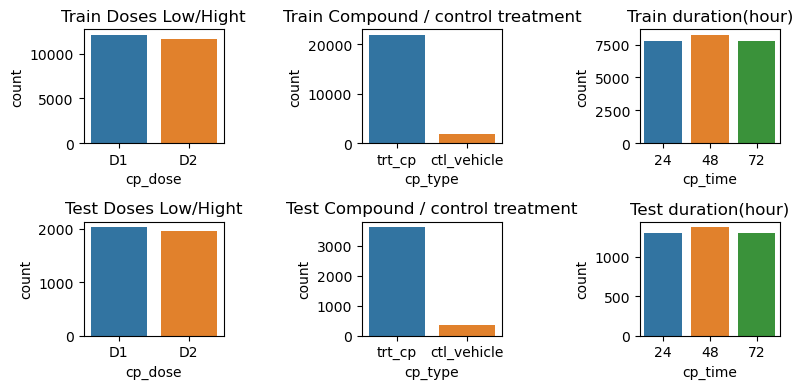

In [24]:
fig,ax=plt.subplots(2,3, figsize=(8,4), dpi=100) 
sns.countplot(train_features["cp_dose"],ax=ax[0,0])
sns.countplot(train_features["cp_type"],ax=ax[0,1])
sns.countplot(train_features["cp_time"],ax=ax[0,2])
sns.countplot(test_features["cp_dose"],ax=ax[1,0])
sns.countplot(test_features["cp_type"],ax=ax[1,1])
sns.countplot(test_features["cp_time"],ax=ax[1,2])
ax[0,0].set_title('Train Doses Low/Hight')
ax[1,0].set_title('Test Doses Low/Hight')
ax[0,1].set_title('Train Compound / control treatment')
ax[1,1].set_title('Test Compound / control treatment')
ax[0,2].set_title('Train duration(hour)')
ax[1,2].set_title('Test duration(hour)')

plt.tight_layout()

In [25]:
train_features.groupby(["cp_type"])["sig_id"].count()

cp_type
ctl_vehicle     1866
trt_cp         21948
Name: sig_id, dtype: int64

We see that our distribution (test and train) are very similar to each other. Samples  control perturbation( ctl_vehicle) is less than 8%.

In [26]:
gens = list(filter(lambda x: x.startswith('g-'),train_features.columns))
cells = list(filter(lambda x: x.startswith('c-'),train_features.columns))
print(f'gen len {len(gens)}, cells len {len(cells)}')

gen len 772, cells len 100


Some distribution of randomly selected columns.

In [27]:
def plot_list(plot_lists,name):
    fig,ax=plt.subplots(1,4, figsize=(10,4), dpi=100) 
    fig.suptitle(name, fontsize=16)
    for i,gen in enumerate(plot_lists):
        train_features.hist(gen,ax=ax[i])
        plt.tight_layout()

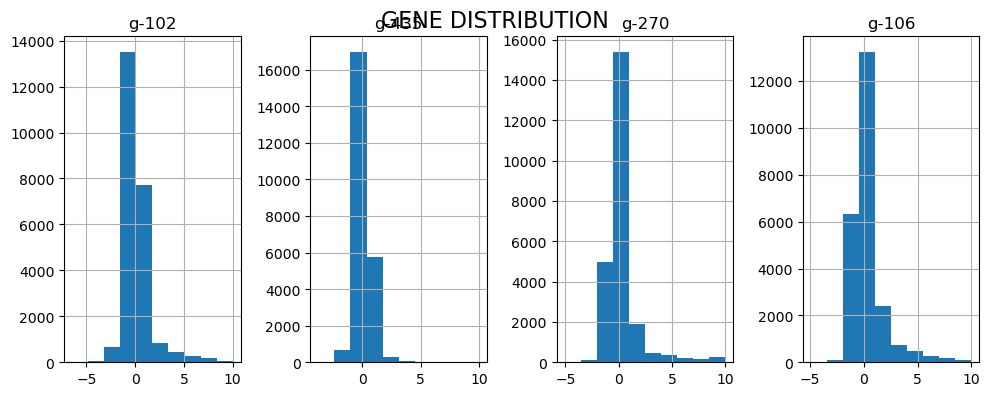

In [28]:
plot_list( [gens[np.random.randint(0, 772)] for i in range(4)],'GENE DISTRIBUTION')

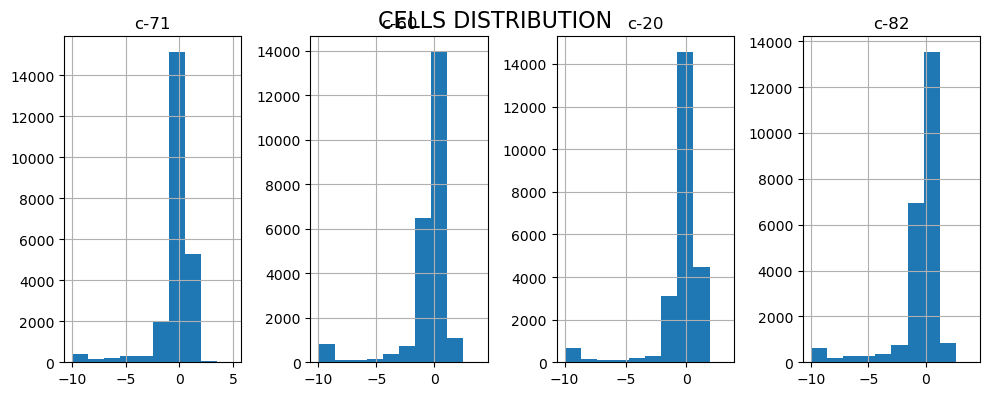

In [29]:
plot_list( [cells[np.random.randint(0, 99)] for i in range(4)],'CELLS DISTRIBUTION')

We can see that our distributions of genes and cells lool like normal,with mean in zero as random following plots show.

# Training features correlation

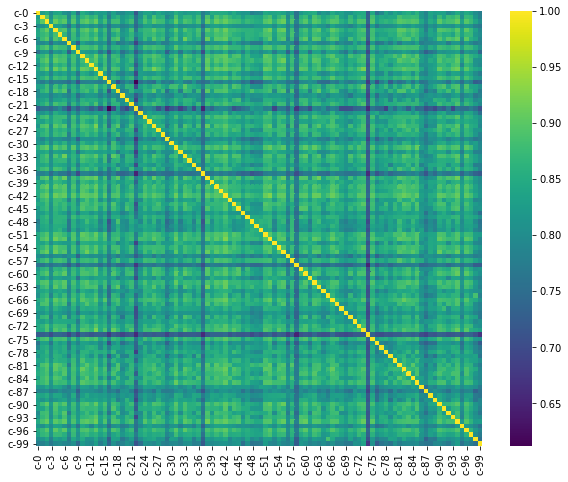

In [30]:
plt.figure(figsize=(10,8))
sns.heatmap(train_features[cells].corr(),cmap='viridis')

There is a clear high correlation between cell viabilities that has to be examined.

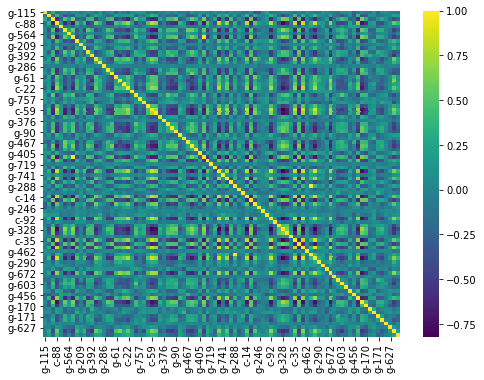

In [31]:
all_list=cells+gens
plt.figure(figsize=(8,6))
sns.heatmap(train_features[list([all_list[np.random.randint(1,len(all_list)-1)] for i in range(90)])].corr(),cmap='viridis')

# Target analysis

In [32]:
target_non_zero=pd.DataFrame(train_targets_scored.drop(["sig_id"],axis=1).sum(axis=0).sort_values().reset_index())
target_non_zero.columns=['name','count_z']

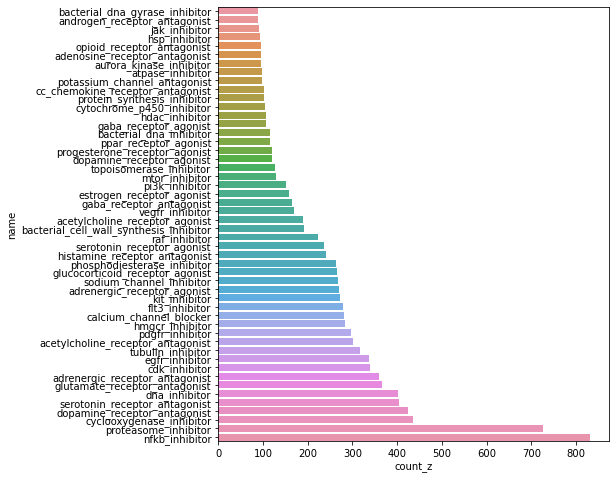

In [33]:
plt.figure(figsize=(7,8))
sns.barplot(data=target_non_zero[-50:],x='count_z',y='name')

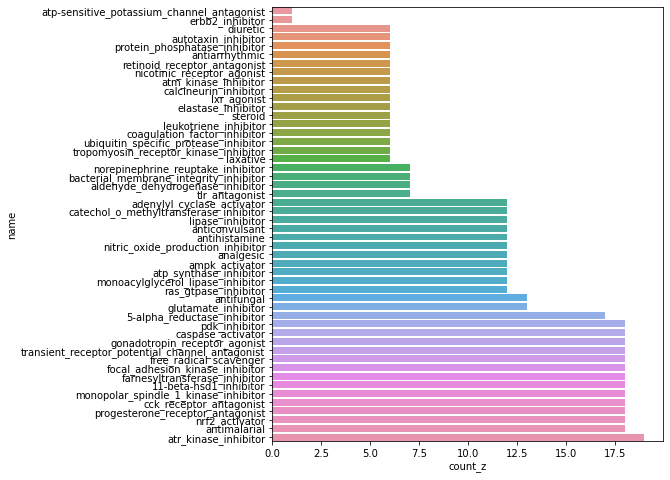

In [34]:
plt.figure(figsize=(7,8))
sns.barplot(data=target_non_zero[:50],x='count_z',y='name')

In [35]:
print(f'it is {target_non_zero[target_non_zero.count_z.values<20].count().values[0]} value that number of positive sample <20 , it is less than 0.1%')


it is 53 value that number of positive sample <20 , it is less than 0.1%


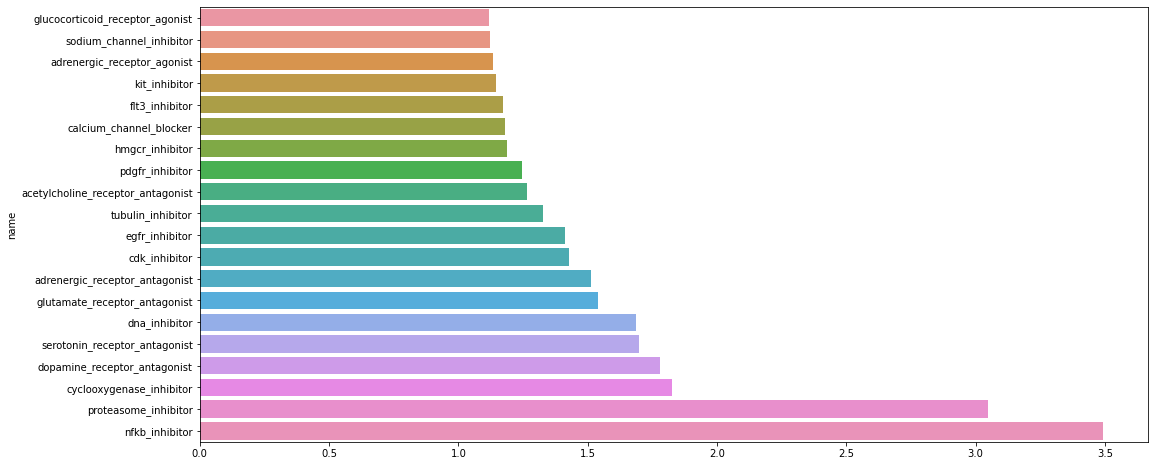

In [36]:
plt.figure(figsize=(17,8))
sns.barplot(y=target_non_zero.name[-20:],x=(target_non_zero.count_z.values/train_targets_scored.shape[0]*100)[-20:])


The highest number of positive sample is 3.5% 

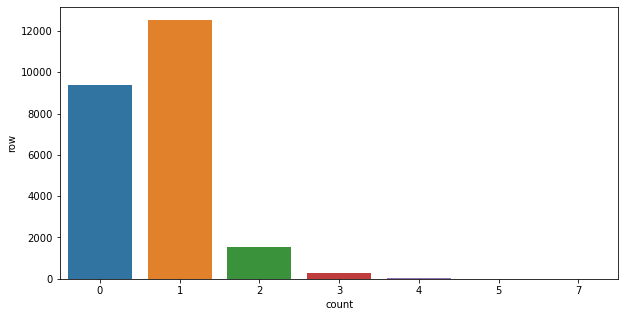

In [37]:
data=train_targets_scored.drop(['sig_id'], axis=1).astype(bool).sum(axis=1).reset_index()
data.columns=['row','count']
data=data.groupby("count")['row'].count().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=data,x='count',y='row')

In [38]:
data['count'].values

array([0, 1, 2, 3, 4, 5, 7])

<Figure size 720x720 with 0 Axes>

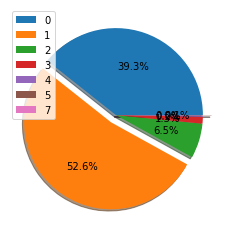

In [39]:

plt.figure(figsize=(10,10))
labels = data['count'].values
explode = (0, 0.1, 0, 0, 0, 0.1, 0)  

fracs = data['row'].values/train_targets_scored.shape[0]*100
# Make figure and axes
fig, axs = plt.subplots()
# A standard pie plot
axs.pie(fracs,  autopct='%1.1f%%', shadow=True,explode=explode)

axs.legend( loc="left",labels=labels)
plt.show()

We see that 40 % of sample have zeros in all columns, and only 53% have only one active target column

In [40]:
train_targets_scored.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.000714,0.000756,0.001008,0.007979,0.012640,0.003065,0.002268,0.004031,0.000504,0.011338,...,0.000252,0.001050,0.002016,0.013270,0.003065,0.000252,0.007139,0.001092,0.001638,0.001260
std,0.026709,0.027483,0.031731,0.088967,0.111716,0.055283,0.047566,0.063365,0.022443,0.105876,...,0.015871,0.032384,0.044851,0.114429,0.055283,0.015871,0.084190,0.033025,0.040436,0.035472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# TRAIN & TARGET CORRELATION

In [41]:
columns=gens+cells

In [42]:
correlation_matrix = pd.DataFrame()

for t_col in train_targets_scored.columns:
    corr_list = list()
    if t_col == 'sig_id':
        continue
    for col in columns:
        res = train_features[col].corr(train_targets_scored[t_col])
        corr_list.append(res)
    correlation_matrix[t_col] = corr_list

In [43]:
correlation_matrix['train_features']=columns
correlation_matrix = correlation_matrix.set_index('train_features')
correlation_matrix


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
train_features,,,,,,,,,,,,,,,,,,,,,
g-0,-0.008317,-0.011513,0.003049,-0.019100,-0.034001,-0.009239,-0.019205,-0.011048,-0.008982,-0.028803,...,-0.005502,-0.005343,-0.011480,-0.035796,-0.011603,-0.005810,0.008336,-0.006992,-0.004046,-0.006481
g-1,-0.004291,-0.004084,-0.000265,-0.005629,0.004920,0.009246,-0.003603,0.006332,-0.001601,0.012687,...,-0.005564,0.009758,0.000162,-0.003212,0.005468,-0.002795,-0.007093,-0.001118,-0.000202,0.000681
g-2,0.000719,-0.002585,-0.004516,-0.004385,-0.016947,0.002133,-0.002664,-0.009920,0.003295,-0.008364,...,0.006100,0.003845,0.007066,0.002302,0.012868,0.003467,0.000210,-0.002793,0.015729,0.002028
g-3,-0.008268,-0.002384,0.001146,-0.007750,-0.010446,-0.013589,-0.002952,-0.002539,0.006999,-0.012385,...,0.014440,-0.012509,-0.014529,-0.006532,-0.000278,-0.000885,0.003360,-0.001645,-0.005706,-0.001866
g-4,-0.003799,0.002661,0.006287,-0.010288,-0.010128,-0.009890,-0.007749,-0.003269,-0.004590,-0.006856,...,-0.000343,-0.000934,-0.008336,-0.022563,-0.002673,0.000025,-0.007507,0.002381,-0.000472,0.003345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c-95,0.010113,0.004202,0.003092,0.022601,0.029189,0.014921,0.016299,0.014628,0.001739,0.022537,...,0.004961,-0.003125,0.010209,-0.066567,-0.003060,0.003947,-0.014844,0.010449,0.009496,0.009497
c-96,0.008570,0.008131,0.010796,0.019768,0.029630,0.012617,0.012412,0.016469,0.006084,0.028096,...,0.002569,-0.000608,0.011297,-0.091944,0.007333,0.002410,0.000934,0.008592,0.014562,0.010589
c-97,0.009440,0.003168,0.009347,0.021624,0.026226,0.016902,0.013411,0.015404,-0.004710,0.027801,...,0.002164,-0.000334,0.010238,-0.121671,0.008242,-0.000108,0.012341,0.005864,0.006122,0.010069


Let's see what is the higher value (absolute) of correlation for target columns with every column from train set

In [44]:
maxCol=lambda x: max(x.min(), x.max(), key=abs)
high_scores = correlation_matrix.apply(maxCol, axis=0).reset_index()
high_scores.columns=["column","corr"]

In [45]:
fig = px.bar(
    high_scores, 
    x='column', 
    y="corr", 
    orientation='v', 
    title='Best correlation with train columns for every target column', 
    width=1200,
    height=800
)

fig.show()

In [46]:
col_df = pd.DataFrame()
tr_cols = list()
tar_cols = list()

for col in correlation_matrix.columns:
    tar_cols.append(col)
    tr_cols.append(
        correlation_matrix[col].abs().sort_values(ascending=False).reset_index()['train_features'].head(1).values[0]
    )

col_df['column'] = tar_cols
col_df['train_best_column'] = tr_cols

total_scores = pd.merge(high_scores, col_df)

total_scores

,column,corr,train_best_column
0,5-alpha_reductase_inhibitor,-0.028704,g-211
1,11-beta-hsd1_inhibitor,-0.018517,g-571
2,acat_inhibitor,-0.018810,g-350
3,acetylcholine_receptor_agonist,-0.033727,g-91
4,acetylcholine_receptor_antagonist,-0.042654,g-392
...,...,...,...
201,ubiquitin_specific_protease_inhibitor,0.017409,g-18
202,vegfr_inhibitor,-0.082568,c-98
203,vitamin_b,-0.027648,g-356
204,vitamin_d_receptor_agonist,0.054114,g-627


Let's take some random columns from target and see their correlation

In [47]:
target_columns = train_targets_scored.columns.tolist()
target_columns.remove('sig_id')
for_analysis = [
    target_columns[
        np.random.randint(0, len(target_columns)-1)
    ] for i in range(5)
]

current_corr = correlation_matrix[for_analysis]

In [48]:
current_corr

,autotaxin_inhibitor,elastase_inhibitor,hsp_inhibitor,btk_inhibitor,antibiotic
train_features,,,,,
g-0,-0.008754,-0.001857,0.030637,-0.001119,0.006609
g-1,0.000623,0.005523,0.041654,-0.000661,-0.002177
g-2,0.000414,-0.006970,0.044328,-0.009393,-0.002959
g-3,0.002972,0.003596,0.145871,0.002907,-0.009209
g-4,-0.000067,0.012873,0.000288,-0.009967,-0.009546
...,...,...,...,...,...
c-95,0.004370,0.003644,-0.099582,0.008553,0.004855
c-96,0.003923,0.004352,-0.039811,0.008208,0.004292
c-97,0.002530,0.001985,-0.052919,0.010656,0.001773


In [49]:
col_df=pd.DataFrame()
first_col=list()
second_col=list()
tar_cols = list()
for col in current_corr.columns:
    tar_cols.append(col)
    first_col.append(current_corr[col].abs().sort_values(ascending=False).reset_index()['train_features'].values[0])
    second_col.append(current_corr[col].abs().sort_values(ascending=False).reset_index()['train_features'].values[1])
col_df['column']=tar_cols
col_df['train_1_column']=first_col
col_df['train_2_column']=second_col
col_df

,column,train_1_column,train_2_column
0,autotaxin_inhibitor,g-706,g-362
1,elastase_inhibitor,g-99,g-5
2,hsp_inhibitor,g-117,g-48
3,btk_inhibitor,g-149,g-543
4,antibiotic,g-158,g-765


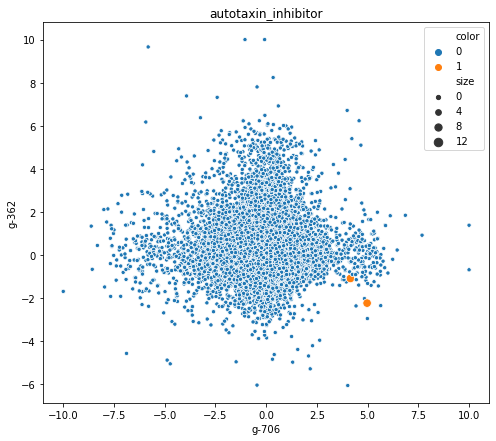

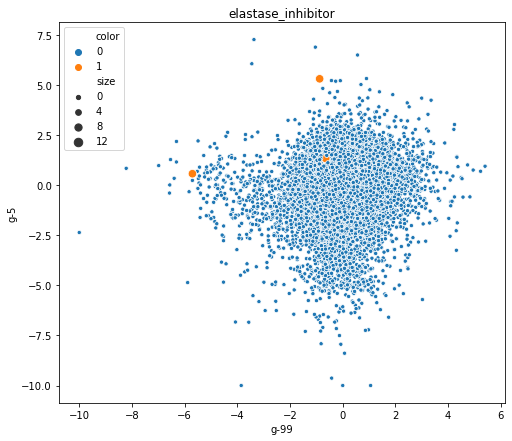

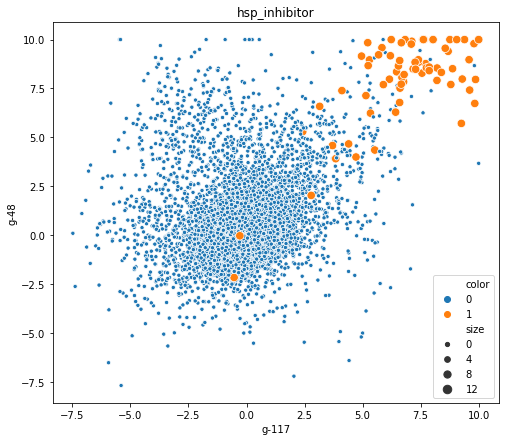

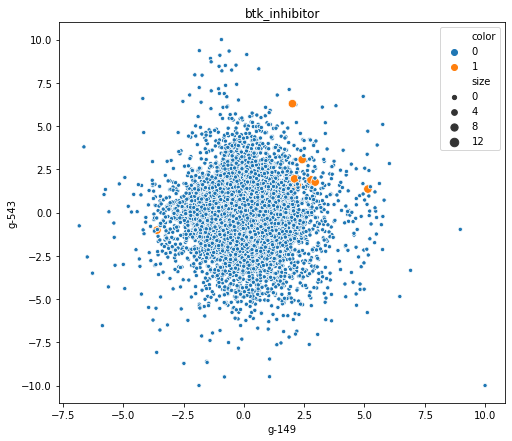

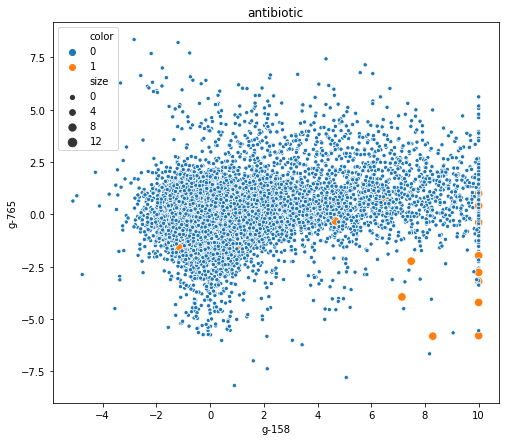

In [50]:
for i in range(col_df.shape[0]):
    analysis = pd.DataFrame()
    analysis['color'] = train_targets_scored[col_df.iloc[i]['column']]
    analysis['x'] = train_features[col_df.iloc[i]['train_1_column']]
    analysis['y'] = train_features[col_df.iloc[i]['train_2_column']]
    analysis.columns = [
        'color', 
        col_df.iloc[i]['train_1_column'], 
        col_df.iloc[i]['train_2_column']
    ]
    analysis['size'] = 1
    analysis.loc[analysis['color'] == 1, 'size'] = 12
    plt.figure(figsize=(8,7))
    plt.title(col_df.iloc[i]['column'])
    sns.scatterplot(x=col_df.iloc[i]['train_1_column'],y=col_df.iloc[i]['train_2_column'], data=analysis,hue='color',size='size')

If we look to the name of target columns, it is look like the last term in the columns name is definition of a group.

In [51]:
target_columns

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist',
 'adrenergic_receptor_antagonist',
 'akt_inhibitor',
 'aldehyde_dehydrogenase_inhibitor',
 'alk_inhibitor',
 'ampk_activator',
 'analgesic',
 'androgen_receptor_agonist',
 'androgen_receptor_antagonist',
 'anesthetic_-_local',
 'angiogenesis_inhibitor',
 'angiotensin_receptor_antagonist',
 'anti-inflammatory',
 'antiarrhythmic',
 'antibiotic',
 'anticonvulsant',
 'antifungal',
 'antihistamine',
 'antimalarial',
 'antioxidant',
 'antiprotozoal',
 'antiviral',
 'apoptosis_stimulant',
 'aromatase_inhibitor',
 'atm_kinase_inhibitor',
 'atp-sensitive_potassium_channel_antagonist',
 'atp_synthase_inhibitor',
 'atpase_inhibitor',
 'atr_kinase_inhibitor',
 'aurora_kinase_inhibitor',
 '

In [52]:
last_term={}
for col in target_columns:
    try:
        last_term[col.split('_')[-1]] += 1
    except:
        last_term[col.split('_')[-1]] = 1
last_term=pd.DataFrame(last_term.items(),columns=['name','count'])
last_term=last_term[last_term['count']>1].sort_values('count')
fig = px.bar(
    last_term, 
    x='name', 
    y="count", 
    orientation='v', 
    title='Group of target columns', 
    width=800,
    height=500
)

fig.show()
    

In [53]:
answer = list()

for group in last_term.name.tolist():
    agent_list = list()
    for item in target_columns:
        if item.split('_')[-1] == group:
            
            agent_list.append(item)
    agent_df = train_targets_scored[agent_list]
    data = agent_df.astype(bool).sum(axis=1).reset_index()
    answer.append(data[0].max())
answer_df=pd.DataFrame({'columns':last_term.name.tolist(),'value':answer})
fig = px.bar(
    answer_df, 
    x='columns', 
    y="value", 
    orientation='v', 
    title='Maximum number of active columns in one sample in every group', 
    width=800,
    height=500
)

fig.show()
    

# Target categorical column(dependecies)

In [54]:
cat_var=['cp_type','cp_time','cp_dose']
cat_df=pd.concat([train_features[cat_var],train_targets_scored.drop('sig_id',axis=1)],axis=1)
cat_df

,cp_type,cp_time,cp_dose,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,trt_cp,24,D1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,trt_cp,72,D1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,trt_cp,48,D1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,trt_cp,48,D1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,trt_cp,72,D2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,trt_cp,24,D2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,trt_cp,24,D2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,ctl_vehicle,48,D2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,trt_cp,24,D1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
def find_targets_zero(cat_var):
    dict_cat={}
    for i in cat_var:
        for cat in np.unique(cat_df[i]):
            name_columns=[]
            for col in cat_df.columns:
                if col in cat_var:
                    continue
                else: 
                    if len(cat_df[cat_df[i]== cat][col].value_counts())==1:
                        name_columns.append(col)
            dict_cat[cat]=name_columns
    return dict_cat
                    
    

In [56]:
result=find_targets_zero(cat_var)


Lets see zero targets.

In [57]:
for key,value in result.items():
    if len(value) >10 :
        print(f'the number of zero target for {key} is {len(value)}')
    else:
        print(f'{key}:{value}')


the number of zero target for ctl_vehicle is 206
trt_cp:[]
24:['atp-sensitive_potassium_channel_antagonist', 'erbb2_inhibitor']
48:[]
72:['atp-sensitive_potassium_channel_antagonist', 'erbb2_inhibitor']
D1:[]
D2:['atp-sensitive_potassium_channel_antagonist', 'erbb2_inhibitor']


We see :
1. that for column cp_type all records are zero where cp_type=ctl_vehicle 
2. for column cp_time=24 ,records 'atp-sensitive_potassium_channel_antagonist', 'erbb2_inhibitor' is zero
3. for column cp_time=72 ,records 'atp-sensitive_potassium_channel_antagonist', 'erbb2_inhibitor' is zero
4. for column cp_dose=D2 ,records 'atp-sensitive_potassium_channel_antagonist', 'erbb2_inhibitor' is zero
 

# QuantileTransformer

In [58]:
from sklearn.preprocessing import QuantileTransformer

In [59]:
SEED_VALUE = 42

In [60]:
vec_len = train_features.shape[0]
vec_len_test =test_features.shape[0]
for col in (gens + cells):
    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
   
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)
    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

# PCA

In [61]:
# GENES
n_comp = 600

data = pd.concat([pd.DataFrame(train_features[gens]), pd.DataFrame(test_features[gens])])
data2 = (PCA(n_components=n_comp, random_state=SEED_VALUE).fit_transform(data[gens]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

print('train_features: {}'.format(train_features.shape))
print('test_features: {}'.format(test_features.shape))


train_features: (23814, 1476)
test_features: (3982, 1476)


In [62]:
# CELLS
n_comp = 50

data = pd.concat([pd.DataFrame(train_features[cells]), pd.DataFrame(test_features[cells])])
data2 = (PCA(n_components=n_comp, random_state=SEED_VALUE).fit_transform(data[cells]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

print('train_features: {}'.format(train_features.shape))
print('test_features: {}'.format(test_features.shape))

train_features: (23814, 1526)
test_features: (3982, 1526)


# Variance Encoding

In [63]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.8)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]

train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)

test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

print('train_features: {}'.format(train_features.shape))
print('test_features: {}'.format(test_features.shape))

train_features: (23814, 1040)
test_features: (3982, 1040)


# ___________________________________

In [64]:
train_features.shape

(23814, 1040)

In [65]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train.merge(train_targets_nonscored, on='sig_id')
train = train.merge(train_drug, on='sig_id')
train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)

In [66]:
train = train.drop('cp_type',axis=1)
test = test.drop('cp_type',axis=1)

In [67]:
train.head(5)

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor,drug_id
0,id_000644bb2,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,...,0,0,0,0,0,0,0,0,0,b68db1d53
1,id_000779bfc,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,...,0,0,0,0,0,0,0,0,0,df89a8e5a
2,id_000a6266a,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,...,0,0,0,0,0,0,0,0,0,18bb41b2c
3,id_0015fd391,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,...,0,0,0,0,0,0,0,0,0,8c7f86626
4,id_001626bd3,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,...,0,0,0,0,0,0,0,0,0,7cbed3131


In [68]:
target_cols = [x for x in train_targets_scored.columns if x != 'sig_id']
aux_target_cols = [x for x in train_targets_nonscored.columns if x != 'sig_id']
all_target_cols = target_cols + aux_target_cols

num_targets = len(target_cols)
num_aux_targets = len(aux_target_cols)
num_all_targets = len(all_target_cols)

print('num_targets: {}'.format(num_targets))
print('num_aux_targets: {}'.format(num_aux_targets))
print('num_all_targets: {}'.format(num_all_targets))

num_targets: 206
num_aux_targets: 402
num_all_targets: 608


In [69]:
print(train.shape)
print(test.shape)
print(sample_submission.shape)

(21948, 1648)
(3624, 1039)
(3982, 207)


# Dataset Classes

In [70]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }

        return dct

In [71]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    return final_loss

def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    return preds


In [72]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1

        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# Model

In [73]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets):
        super(Model, self).__init__()
        self.hidden_size = [1500, 1250, 1000, 750]
        self.dropout_value = [0.5, 0.35, 0.3, 0.25]

        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.Linear(num_features, self.hidden_size[0])
        
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size[0])
        self.dropout2 = nn.Dropout(self.dropout_value[0])
        self.dense2 = nn.Linear(self.hidden_size[0], self.hidden_size[1])

        self.batch_norm3 = nn.BatchNorm1d(self.hidden_size[1])
        self.dropout3 = nn.Dropout(self.dropout_value[1])
        self.dense3 = nn.Linear(self.hidden_size[1], self.hidden_size[2])

        self.batch_norm4 = nn.BatchNorm1d(self.hidden_size[2])
        self.dropout4 = nn.Dropout(self.dropout_value[2])
        self.dense4 = nn.Linear(self.hidden_size[2], self.hidden_size[3])

        self.batch_norm5 = nn.BatchNorm1d(self.hidden_size[3])
        self.dropout5 = nn.Dropout(self.dropout_value[3])
        self.dense5 = nn.utils.weight_norm(nn.Linear(self.hidden_size[3], num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))

        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))

        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))

        x = self.batch_norm5(x)
        x = self.dropout5(x)
        x = self.dense5(x)
        return x
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))  

In [74]:
class FineTuneScheduler:
    def __init__(self, epochs):
        self.epochs = epochs
        self.epochs_per_step = 0
        self.frozen_layers = []

    def copy_without_top(self, model, num_features, num_targets, num_targets_new):
        self.frozen_layers = []

        model_new = Model(num_features, num_targets)
        model_new.load_state_dict(model.state_dict())

        # Freeze all weights
        for name, param in model_new.named_parameters():
            layer_index = name.split('.')[0][-1]

            if layer_index == 5:
                continue

            param.requires_grad = False

            # Save frozen layer names
            if layer_index not in self.frozen_layers:
                self.frozen_layers.append(layer_index)

        self.epochs_per_step = self.epochs // len(self.frozen_layers)

        # Replace the top layers with another ones
        model_new.batch_norm5 = nn.BatchNorm1d(model_new.hidden_size[3])
        model_new.dropout5 = nn.Dropout(model_new.dropout_value[3])
        model_new.dense5 = nn.utils.weight_norm(nn.Linear(model_new.hidden_size[-1], num_targets_new))
        model_new.to(DEVICE)
        return model_new

    def step(self, epoch, model):
        if len(self.frozen_layers) == 0:
            return

        if epoch % self.epochs_per_step == 0:
            last_frozen_index = self.frozen_layers[-1]
            
            # Unfreeze parameters of the last frozen layer
            for name, param in model.named_parameters():
                layer_index = name.split('.')[0][-1]

                if layer_index == last_frozen_index:
                    param.requires_grad = True

            del self.frozen_layers[-1]  # Remove the last layer as unfrozen

# Preprocessing steps

In [75]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [76]:
feature_cols = [c for c in process_data(train).columns if c not in all_target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id', 'drug_id']]
num_features = len(feature_cols)
num_features

1041

In [77]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 24
BATCH_SIZE = 128

WEIGHT_DECAY = {'ALL_TARGETS': 1e-5, 'SCORED_ONLY': 3e-6}
MAX_LR = {'ALL_TARGETS': 1e-2, 'SCORED_ONLY': 3e-3}
DIV_FACTOR = {'ALL_TARGETS': 1e3, 'SCORED_ONLY': 1e2}
PCT_START = 0.1

In [78]:
# Show model architecture
model = Model(num_features, num_all_targets)
model

Model(
  (batch_norm1): BatchNorm1d(1041, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=1041, out_features=1500, bias=True)
  (batch_norm2): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=1500, out_features=1250, bias=True)
  (batch_norm3): BatchNorm1d(1250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.35, inplace=False)
  (dense3): Linear(in_features=1250, out_features=1000, bias=True)
  (batch_norm4): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (dense4): Linear(in_features=1000, out_features=750, bias=True)
  (batch_norm5): BatchNorm1d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout5): Dropout(p=0.25, inplace=False)
  (dense5): Linear(in_features=750, out_features=608, 

# Single fold training

In [79]:
from sklearn.model_selection import KFold

def make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH):
    vc = train.drug_id.value_counts()
    vc1 = vc.loc[vc <= DRUG_THRESH].index.sort_values()
    vc2 = vc.loc[vc > DRUG_THRESH].index.sort_values()

    for seed_id in range(SEEDS):
        kfold_col = 'kfold_{}'.format(seed_id)
        
        # STRATIFY DRUGS 18X OR LESS
        dct1 = {}
        dct2 = {}

        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.groupby('drug_id')[target_cols].mean().loc[vc1]

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.index[idxV].values}
            dct1.update(dd)

        # STRATIFY DRUGS MORE THAN 18X
        skf = MultilabelStratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed_id)
        tmp = train.loc[train.drug_id.isin(vc2)].reset_index(drop=True)

        for fold,(idxT, idxV) in enumerate(skf.split(tmp, tmp[target_cols])):
            dd = {k: fold for k in tmp.sig_id[idxV].values}
            dct2.update(dd)

        # ASSIGN FOLDS
        train[kfold_col] = train.drug_id.map(dct1)
        train.loc[train[kfold_col].isna(), kfold_col] = train.loc[train[kfold_col].isna(), 'sig_id'].map(dct2)
        train[kfold_col] = train[kfold_col].astype('int8')
        
    return train

SEEDS = 7
NFOLDS = 7
DRUG_THRESH = 18

train = make_cv_folds(train, SEEDS, NFOLDS, DRUG_THRESH)
train.head()

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,xanthine_oxidase_inhibitor,xiap_inhibitor,drug_id,kfold_0,kfold_1,kfold_2,kfold_3,kfold_4,kfold_5,kfold_6
0,id_000644bb2,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,...,0,0,b68db1d53,1,3,3,5,0,5,2
1,id_000779bfc,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,...,0,0,df89a8e5a,0,3,6,3,3,4,1
2,id_000a6266a,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,...,0,0,18bb41b2c,5,3,3,1,3,0,4
3,id_0015fd391,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,...,0,0,8c7f86626,4,3,1,2,4,5,2
4,id_001626bd3,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,...,0,0,7cbed3131,6,5,3,3,2,1,4


In [80]:
def run_training(fold_id, seed_id):
    seed_everything(seed_id)
    
    train_ = process_data(train)
    test_ = process_data(test)
    
    kfold_col = f'kfold_{seed_id}'
    trn_idx = train_[train_[kfold_col] != fold_id].index
    val_idx = train_[train_[kfold_col] == fold_id].index
    
    train_df = train_[train_[kfold_col] != fold_id].reset_index(drop=True)
    valid_df = train_[train_[kfold_col] == fold_id].reset_index(drop=True)
    
    def train_model(model, tag_name, target_cols_now, fine_tune_scheduler=None):
        x_train, y_train  = train_df[feature_cols].values, train_df[target_cols_now].values
        x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols_now].values
        
        train_dataset = MoADataset(x_train, y_train)
        valid_dataset = MoADataset(x_valid, y_valid)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY[tag_name])
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                  steps_per_epoch=len(trainloader),
                                                  pct_start=PCT_START,
                                                  div_factor=DIV_FACTOR[tag_name], 
                                                  max_lr=MAX_LR[tag_name],
                                                  epochs=EPOCHS)
        
        loss_fn = nn.BCEWithLogitsLoss()
        loss_tr = SmoothBCEwLogits(smoothing=0.001)

        oof = np.zeros((len(train), len(target_cols_now)))
        best_loss = np.inf
        
        for epoch in range(EPOCHS):
            if fine_tune_scheduler is not None:
                fine_tune_scheduler.step(epoch, model)

            train_loss = train_fn(model, optimizer, scheduler, loss_tr, trainloader, DEVICE)
            valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
            print(f"SEED: {seed_id}, FOLD: {fold_id}, {tag_name}, EPOCH: {epoch}, train_loss: {train_loss:.6f}, valid_loss: {valid_loss:.6f}")

            if np.isnan(valid_loss):
                break
            
            if valid_loss < best_loss:
                best_loss = valid_loss
                oof[val_idx] = valid_preds
                torch.save(model.state_dict(), f"{tag_name}_FOLD{fold_id}_.pth")

        return oof

    fine_tune_scheduler = FineTuneScheduler(EPOCHS)

    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.to(DEVICE)

    # Train on scored + nonscored targets
    train_model(pretrained_model, 'ALL_TARGETS', all_target_cols)

    # Load the pretrained model with the best loss
    pretrained_model = Model(num_features, num_all_targets)
    pretrained_model.load_state_dict(torch.load(f"ALL_TARGETS_FOLD{fold_id}_.pth"))
    pretrained_model.to(DEVICE)

    # Copy model without the top layer
    final_model = fine_tune_scheduler.copy_without_top(pretrained_model, num_features, num_all_targets, num_targets)

    # Fine-tune the model on scored targets only
    oof = train_model(final_model, 'SCORED_ONLY', target_cols, fine_tune_scheduler)

    # Load the fine-tuned model with the best loss
    model = Model(num_features, num_targets)
    model.load_state_dict(torch.load(f"SCORED_ONLY_FOLD{fold_id}_.pth"))
    model.to(DEVICE)

    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    predictions = np.zeros((len(test_), num_targets))
    predictions = inference_fn(model, testloader, DEVICE)
    return oof, predictions
def run_k_fold(NFOLDS, seed_id):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold_id in range(NFOLDS):
        oof_, pred_ = run_training(fold_id, seed_id)
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [81]:
from time import time

# Averaging on multiple SEEDS
SEED = [0]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

time_begin = time()

for seed_id in SEED:
    oof_, predictions_ = run_k_fold(NFOLDS, seed_id)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

time_diff = time() - time_begin

train[target_cols] = oof
test[target_cols] = predictions

SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 0, train_loss: 0.495610, valid_loss: 0.021284
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 1, train_loss: 0.015629, valid_loss: 0.009848
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 2, train_loss: 0.013328, valid_loss: 0.009263
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 3, train_loss: 0.013122, valid_loss: 0.009140
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 4, train_loss: 0.013095, valid_loss: 0.009121
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 5, train_loss: 0.012921, valid_loss: 0.009352
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 6, train_loss: 0.012902, valid_loss: 0.009286
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 7, train_loss: 0.012890, valid_loss: 0.010631
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 8, train_loss: 0.012900, valid_loss: 0.009195
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 9, train_loss: 0.012868, valid_loss: 0.008979
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 10, train_loss: 0.012853, valid_loss: 0.009093
SEED: 0, FOLD: 0, ALL_TARGETS, EPOCH: 11, train_loss: 0.012851, valid_loss:

SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 1, train_loss: 0.015656, valid_loss: 0.010687
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 2, train_loss: 0.013427, valid_loss: 0.010113
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 3, train_loss: 0.012958, valid_loss: 0.009677
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 4, train_loss: 0.012882, valid_loss: 0.010883
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 5, train_loss: 0.012849, valid_loss: 0.010797
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 6, train_loss: 0.012828, valid_loss: 0.009812
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 7, train_loss: 0.012812, valid_loss: 0.009979
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 8, train_loss: 0.012812, valid_loss: 0.009957
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 9, train_loss: 0.012790, valid_loss: 0.009695
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 10, train_loss: 0.012769, valid_loss: 0.009868
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 11, train_loss: 0.012797, valid_loss: 0.009652
SEED: 0, FOLD: 2, ALL_TARGETS, EPOCH: 12, train_loss: 0.012765, valid_loss

SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 2, train_loss: 0.013352, valid_loss: 0.009660
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 3, train_loss: 0.013007, valid_loss: 0.009475
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 4, train_loss: 0.012932, valid_loss: 0.009494
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 5, train_loss: 0.012932, valid_loss: 0.010536
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 6, train_loss: 0.012910, valid_loss: 0.009500
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 7, train_loss: 0.012809, valid_loss: 0.009861
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 8, train_loss: 0.012859, valid_loss: 0.009608
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 9, train_loss: 0.012830, valid_loss: 0.009735
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 10, train_loss: 0.012817, valid_loss: 0.009375
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 11, train_loss: 0.012803, valid_loss: 0.009392
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 12, train_loss: 0.012797, valid_loss: 0.009403
SEED: 0, FOLD: 4, ALL_TARGETS, EPOCH: 13, train_loss: 0.012791, valid_los

SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 3, train_loss: 0.014329, valid_loss: 0.010292
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 4, train_loss: 0.013324, valid_loss: 0.010109
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 5, train_loss: 0.013008, valid_loss: 0.009913
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 6, train_loss: 0.012901, valid_loss: 0.009837
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 7, train_loss: 0.012864, valid_loss: 0.010083
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 8, train_loss: 0.012828, valid_loss: 0.009799
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 9, train_loss: 0.012803, valid_loss: 0.009831
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 10, train_loss: 0.012784, valid_loss: 0.009785
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 11, train_loss: 0.012769, valid_loss: 0.009729
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 12, train_loss: 0.012721, valid_loss: 0.009683
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 13, train_loss: 0.012702, valid_loss: 0.009720
SEED: 0, FOLD: 6, ALL_TARGETS, EPOCH: 14, train_loss: 0.012645, valid_lo

In [82]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0

for i in range(len(target_cols)):
    score += log_loss(y_true[:, i], y_pred[:, i])

print("CV log_loss: ", score / y_pred.shape[1])

CV log_loss:  0.015930826930558264


In [83]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)